In [12]:
import pandas as pd
import numpy as np
import requests
import spacy
import logging
import os 
import re
import json
import datetime
import gzip
from datetime import datetime, timedelta
from dateutil import parser, relativedelta
from localutils import cveutils

# set up the current date and time as one string
current_date = datetime.now().strftime('%Y-%m-%d')
current_time = datetime.now().strftime('%H:%M:%S')


#Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"logs/app-{current_date+current_time}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ExploitDB
from pyExploitDb import PyExploitDb
pEdb = PyExploitDb()
pEdb.debug = False
pEdb.openFile()


In [ ]:
# Download and unzip NVD CVE data
def download_nvd_cve_data(start_year, end_year, directory):
    base_url = "https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{}.json.zip"
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(directory, f"nvdcve-1.1-{year}.json.zip")
        if os.path.exists(file_path):
            logger.info(f"File {file_path} already exists, skipping download.")
            continue
        
        url = base_url.format(year)
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
            logger.info(f"Downloaded {file_path}")
        else:
            logger.error(f"Failed to download data for year {year}")

# unzip all found files in the directory
def unzip_files(directory):
    import zipfile
    import os
    
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            file_path = os.path.join(directory, file)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(directory)
                logger.info(f"Unzipped {file_path}")
                os.remove(file_path)

# Load NVD CVE data into a DataFrame
def load_nvd_cve_data(directory):
    data = []
    cves_list = []
    for file in os.listdir(directory):
        if file.endswith(".json"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as file:
                data = json.load(file)
                logger.info(f"Loaded {file_path}")
                for index, item in enumerate(data.get("CVE_Items", [])):
                    cve = (
                        item.get("cve", {}).get("CVE_data_meta", {}).get("ID", ""), 
                        item.get("cve", {}).get("description", {}).get("description_data", [{}])[0].get("value", ""),
                        item.get("publishedDate", ""),
                        item.get("lastModifiedDate", ""),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("version", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("version", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("vectorString", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("vectorString", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("attackVector", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("accessVector", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("attackComplexity", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("accessComplexity", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("privilegesRequired", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("authentication", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("userInteraction", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("userInteraction", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("baseScore", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("baseScore", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("baseSeverity", item.get("impact", {}).get("baseMetricV2", {}).get("severity", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("exploitabilityScore", item.get("impact", {}).get("baseMetricV2", {}).get("exploitabilityScore", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("impactScore", item.get("impact", {}).get("baseMetricV2", {}).get("impactScore", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("scope", item.get("impact", {}).get("baseMetricV2", {}).get("scope", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("confidentialityImpact", item.get("impact", {}).get("baseMetricV2", {}).get("confidentialityImpact", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("integrityImpact", item.get("impact", {}).get("baseMetricV2", {}).get("integrityImpact", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("availabilityImpact", item.get("impact", {}).get("baseMetricV2", {}).get("availabilityImpact", "")),
                    )
                    cves_list.append(cve)

    cves_df = pd.DataFrame(cves_list, columns=["cve_id", "description", "published_date", "last_modified_date", "cvss_version", "cvss_vector", "attack_vector", "attack_complexity", "privileges_required", "user_interaction", "base_score", "base_severity", "exploitability_score", "impact_score", "scope", "confidentiality_impact", "integrity_impact", "availability_impact"])
    return cves_df

# Download EPSS scores and ungzip them
def download_epss_scores(date, directory):
    # Download EPSS scores for a given date -1 day
    yesterday = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=1)
    yesterday = yesterday.strftime("%Y-%m-%d")
    file_path = os.path.join(directory, f"epss_scores-{yesterday}.csv.gz")
    try:
        if not os.path.exists(file_path):
            logger.info(f"Downloading EPSS scores for date {yesterday}")
            url = f"https://epss.cyentia.com/epss_scores-{yesterday}.csv.gz"
            response = requests.get(url)
            if response.status_code == 200:
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                logger.info(f"Downloaded {file_path}")
        else:
            logger.info(f"File {file_path} already exists, skipping download.")

        logger.info(f"Unzipping {file_path}")
        with gzip.open(file_path, 'rb') as file_in:
            with open(file_path.replace(".gz", ""), 'wb') as file_out:
                file_out.write(file_in.read())
            return file_path.replace(".gz", "")
    except Exception as e:
        logger.error(f"Failed to download EPSS scores for date {date}: {e}")
        return None

# Check on exploitability against exploitdb data
def get_exploitdb_data(cve_id):
    """
    Get the ExploitDB data for a given CVE ID.
    """
    try:
        logger.info(f"Searching ExploitDB data for {cve_id}")
        exploitdb_data = pEdb.searchCve(cve_id)
        if exploitdb_data:
            return pd.Series({
                "exploitdb_id": exploitdb_data.get("id", ""),
                "description": exploitdb_data.get("description", ""),
                "date": exploitdb_data.get("date", ""),
                "date_updated": exploitdb_data.get("date_updated", ""),
                "author": exploitdb_data.get("author", ""),
                "type": exploitdb_data.get("type", ""),
                "platform": exploitdb_data.get("platform", ""),
                "port": exploitdb_data.get("port", ""),
                "url": exploitdb_data.get("url", "")
            })
    except Exception as e:
        print(f"Error getting ExploitDB data for {cve_id}: {e}")
        return pd.Series({
            "exploitdb_id": None,
            "description": None,
            "date": None,
            "author": None,
            "type": None,
            "platform": None,
            "port": None,
            "url": None
        })

# Download KEV data  
def download_known_exploited_vulnerabilities():
    url = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
    
    # Download the file and return a DataFrame
    try:
        response = requests.get(url)
        response.raise_for_status()
        file_path = os.path.join("data/download", "known_exploited_vulnerabilities.csv")
        with open(file_path, 'wb') as file:
            file.write(response.content)
        logger.info(f"Downloaded known exploited vulnerabilities to {file_path}")
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading known exploited vulnerabilities: {e}")
        return None
    
# Enrichment with CISAGOV data

from dotenv import load_dotenv
load_dotenv()

token = os.getenv('GH_TOKEN')
header = {'Authorization': f'token {token}'}
url = f"https://api.github.com/repos/cisagov/vulnrichment"
output = requests.get(url,headers=header)
download_dir = "data/download/CISAGOV"

# function which returns a position in the "metrics" list where the "name" key matches the given value
def get_metric_position_of_other(metrics_list):
    for i, metric in enumerate(metrics_list):
        if "other" in metric:
            return i
    return None

# make output flattened
def flatten_vulnrichment_output(vulnrichment_output):
    flattened_output = {}
    for keyval in vulnrichment_output:
        if isinstance(keyval, dict):
            for k, v in keyval.items():
                flattened_output[k] = v
        else:
            return None
    return flattened_output

def cve_vulnrichment(cve_id):
    parts = cve_id.split("-")
    year = parts[1]  # Example: "2021"
    number = int(parts[2])  # Example: "3493" → 3493
    thousands_group = f"{(number // 1000)}xxx"  # Calculate folder name, e.g., 3xxx

    # Construct URL for the JSON file
    file_path = f"{year}/{thousands_group}/{cve_id}.json"
    file_url = f"{url}/contents/{file_path}"

    try:
        # Get the metadata for the file
        metadata_output = requests.get(file_url,headers=header)
        metadata_output.raise_for_status()
        metadata = metadata_output.json()
        download_url = metadata["download_url"]

        # check if the file already exists
        downloaded_file = os.path.join(download_dir, f"{cve_id}.json")
        if os.path.exists(downloaded_file):
            logger.info(f"File {downloaded_file} already exists, skipping download.")
            # read the file and return the options
            with open(downloaded_file, "r") as file:
                cve = json.load(file)
                if cve.get("cveMetadata", {}).get("state") != "REJECTED":
                    adp_list = cve.get("containers", []).get("adp", [])
                    for i, item in enumerate(adp_list):
                        if "CISA ADP Vulnrichment" in item.get("title"):
                            adp_position = i
                    other = adp_list[adp_position].get("metrics", {})
                    position = get_metric_position_of_other(adp_list[adp_position].get("metrics", {}))
                    logger.info(f"Found positions: {adp_position}, {position}")
                    return other[position].get("other").get("content").get("options")
                else:
                    return [{"Exploitation": None}, {"Automatable": None}, {"Technical Impact": None}]

        # Downloading the JSON file
        logger.info(f"Download URL found, downloading: {download_url}")
        json_response = requests.get(download_url)
        json_response.raise_for_status()
        json_data = json_response.json()

        # Create the download folder if it doesn't exist
        os.makedirs(download_dir, exist_ok=True)

        # Save the file locally
        local_file_path = os.path.join(download_dir, f"{cve_id}.json")
        with open(local_file_path, "w") as f:
            json.dump(json_data, f, indent=4)

        logger.info(f"Downloaded and saved {cve_id} to {local_file_path}")
        if json_data.get("cveMetadata", {}).get("state") != "REJECTED":
            adp_list = json_data.get("containers", []).get("adp", [])
            for i, item in enumerate(adp_list):
                if "CISA ADP Vulnrichment" in item.get("title"):
                    adp_position = i
            other = adp_list[adp_position].get("metrics", {})
            position = get_metric_position_of_other(adp_list[adp_position].get("metrics", {}))
            logger.info(f"Found positions: {adp_position}, {position}")
            return other[position].get("other").get("content").get("options")
        else:
            return [{"Exploitation": None}, {"Automatable": None}, {"Technical Impact": None}]
    
    except requests.exceptions.HTTPError as e:
        logger.error(f"Error downloading {cve_id}: {e}")
        return [{"Exploitation": None}, {"Automatable": None}, {"Technical Impact": None}]

# Update the row with the details from the vulnrichment output
def update_row_with_details(row):
    details = flatten_vulnrichment_output(cve_vulnrichment(row['cve_id']))  # Fetch details for the current row's cve_id
    if not details:
        return 
    for key, value in details.items():
        row[key] = value  # Add each detail as a new column to the row
    return row

In [ ]:
download_nvd_cve_data(2005, 2025, "data/download")
unzip_files("data/download")

cves = load_nvd_cve_data("data/download")
# Sort by CVE ID
cves = cves.sort_values(by="cve_id")

cves.to_csv("output/cves_2004-2025.csv", index=False)
today_date = datetime.now().strftime("%Y-%m-%d")
epss_file = download_epss_scores(today_date, "data/download")
epss_scores = pd.read_csv(epss_file, skiprows=1)
cves_with_epss = pd.merge(cves,epss_scores, left_on="cve_id", right_on="cve", how="left")
cves_with_epss.drop(columns=["cve"], inplace=True)
cves_with_epss.to_csv("output/cves_with_epss_2004-2025.csv", index=False)
kevs = download_known_exploited_vulnerabilities()

# simulate identified vulns outcome
outcome_cves = cves_with_epss.sample(1000)
outcome_cves.drop(columns=["scope", "confidentiality_impact", "integrity_impact", "availability_impact"], inplace=True)
outcome_cves = outcome_cves.apply(update_row_with_details, axis=1)
outcome_cves.to_csv("output/outcome_cves_epss_enriched-20250106.csv", index=False)

Analyse cve descriptions to find relevant Categories and re-assess original CVSS impact
(use spacy.io)

In [ ]:
outcome_cves.columns

In [ ]:
# plot the distribution of the base scores for the outcome cves versus EPSS scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(outcome_cves["base_score"], bins=20, kde=True, color="blue", label="Outcome CVEs")
sns.histplot(outcome_cves["epss"], bins=20, kde=True, color="red", label="EPSS Scores")
plt.title("Distribution of Base Scores for Outcome CVEs vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("Count")
plt.legend()
plt.savefig("output/base_scores_distribution.png")
plt.show()


In [ ]:
# generate plot with CVE scores in X and EPSS scores in Y
plt.figure(figsize=(12, 6))
sns.scatterplot(x="base_score", y="epss", data=outcome_cves)
plt.title("Base Scores vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("EPSS Score")
plt.savefig("output/base_vs_epss_scores.png")
plt.show()

# add labels of the CVEs with the highest EPSS scores
highest_epss = outcome_cves.nlargest(5, "epss")
plt.figure(figsize=(12, 6))
sns.scatterplot(x="base_score", y="epss", data=outcome_cves)
for i, row in highest_epss.iterrows():
    plt.text(row["base_score"], row["epss"], row["cve_id"], fontsize=8)
plt.title("Base Scores vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("EPSS Score")
plt.savefig("output/base_vs_epss_scores_with_labels.png")
plt.show()

In [ ]:
# show Bayes' theorem  for the outcome cves with EPSS scores and the known exploited vulnerabilities data 
# calculate the probabilities
total_cves = len(outcome_cves)
total_kevs = len(kevs)
total_epss = len(outcome_cves[outcome_cves["epss"].notnull()])
total_epss_kevs = len(kevs[kevs["cveID"].isin(outcome_cves["cve_id"])])
total_epss_not_kevs = total_epss - total_epss_kevs
total_kevs_not_epss = total_kevs - total_epss_kevs
total_not_epss = total_cves - total_epss
# calculate the probabilities
# Calculate proper probabilities using only the total_cves as the base
p_kevs = total_kevs / total_cves  # P(KEV)
p_epss = total_epss / total_cves  # P(EPSS)
p_kevs_and_epss = total_epss_kevs / total_cves  # P(KEV ∩ EPSS)
p_kevs_given_epss = p_kevs_and_epss / p_epss if p_epss > 0 else 0  # P(KEV|EPSS)
p_epss_given_kevs = p_kevs_and_epss / p_kevs if p_kevs > 0 else 0  # P(EPSS|KEV)
p_not_epss = 1 - p_epss  # P(not EPSS)
p_kevs_and_not_epss = total_kevs_not_epss / total_cves  # P(KEV ∩ not EPSS)
p_kevs_given_not_epss = p_kevs_and_not_epss / p_not_epss if p_not_epss > 0 else 0  # P(KEV|not EPSS)
p_not_epss_given_kevs = 1 - p_epss_given_kevs  # P(not EPSS|KEV)
# print the probabilities
print(f"Total CVEs: {total_cves}")
print(f"Total KEVs: {total_kevs}")
print(f"Total EPSS: {total_epss}")
print(f"Total EPSS KEVs: {total_epss_kevs}")
print(f"Total EPSS not KEVs: {total_epss_not_kevs}")
print(f"Total KEVs not EPSS: {total_kevs_not_epss}")
print(f"Total not EPSS: {total_not_epss}")
print(f"Probability of KEVs: {p_kevs}")
print(f"Probability of EPSS: {p_epss}")
print(f"Probability of KEVs and EPSS: {p_kevs_and_epss}")
print(f"Probability of KEVs given EPSS: {p_kevs_given_epss}")
print(f"Probability of EPSS given KEVs: {p_epss_given_kevs}")
print(f"Probability of KEVs and not EPSS: {p_kevs_and_not_epss}")
print(f"Probability of not EPSS: {p_not_epss}")
print(f"Probability of KEVs given not EPSS: {p_kevs_given_not_epss}")
print(f"Probability of not EPSS given KEVs: {p_not_epss_given_kevs}")


In [ ]:
# download epps scores for the the last given months to a given directory and unzip them there
def download_epss_scores_for_months(months, directory):
    
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")
    
    for i in range(months):
        date = datetime.datetime.strptime(today_date, "%Y-%m-%d") - datetime.timedelta(days=30 * i)
        date = date.replace(day=1).strftime("%Y-%m-%d")
        file_path = download_epss_scores(date, directory)
        if file_path:
            epss_scores = pd.read_csv(file_path)
            epss_scores["date"] = date
            epss_scores.to_csv(f"{directory}/epss_scores-{date}.csv", index=False)
        else:
            logger.error(f"Failed to download EPSS scores for date {date}")

In [ ]:
# given the today date find me the last 6 months of EPSS scores starting first of the month
download_epss_scores_for_months(12, "data/download/EPSS")

In [124]:
def download_epss_scores_for_months(number, directory, unit='months'):
    """
    Download EPSS scores for a given number of months or days
    
    Args:
        number (int): Number of time units to go back
        directory (str): Directory to save the files
        unit (str): Time unit to use ('months' or 'days')
    
    Returns:
        list: List of downloaded file paths
    """
    today_date = datetime.now().strftime("%Y-%m-%d")
    files = []
    
    for i in range(number):
        # Start with today's date, set it to 1st of current month, then go back
        date = datetime.strptime(today_date, "%Y-%m-%d")
        if unit == 'months':
            # For months, always set to 1st of the month and subtract months
            date = date.replace(day=1)
            date = date - relativedelta.relativedelta(months=i)
        else:
            # For days, just subtract days
            date = date - timedelta(days=i)
            
        date_str = date.strftime("%Y-%m-%d")
        file_path = cveutils.download_epss_scores(date_str, directory)
        if file_path:
            files.append(file_path)
            
    return files



In [127]:
files_to_process = download_epss_scores_for_months(30, "data/download/EPSS_daily", unit='days')

2025-02-09 15:22:48,762 - INFO - Downloading EPSS scores for date 2025-02-08
2025-02-09 15:22:48,971 - INFO - Downloaded data/download/EPSS_daily/epss_scores-2025-02-08.csv.gz
2025-02-09 15:22:48,973 - INFO - Unzipping data/download/EPSS_daily/epss_scores-2025-02-08.csv.gz
2025-02-09 15:22:49,087 - INFO - Downloading EPSS scores for date 2025-02-07
2025-02-09 15:22:49,300 - INFO - Downloaded data/download/EPSS_daily/epss_scores-2025-02-07.csv.gz
2025-02-09 15:22:49,301 - INFO - Unzipping data/download/EPSS_daily/epss_scores-2025-02-07.csv.gz
2025-02-09 15:22:49,372 - INFO - Downloading EPSS scores for date 2025-02-06
2025-02-09 15:22:49,584 - INFO - Downloaded data/download/EPSS_daily/epss_scores-2025-02-06.csv.gz
2025-02-09 15:22:49,586 - INFO - Unzipping data/download/EPSS_daily/epss_scores-2025-02-06.csv.gz
2025-02-09 15:22:49,659 - INFO - Downloading EPSS scores for date 2025-02-05
2025-02-09 15:22:49,870 - INFO - Downloaded data/download/EPSS_daily/epss_scores-2025-02-05.csv.gz
20

In [128]:
epss_dfs = []
for i, file in enumerate(files_to_process):
    with open(file, "r") as f:
        first_line = f.readline().strip()
        score_date = first_line.split(",")[1].split(":")[1].strip().split("T")[0]
        score_date = datetime.strptime(score_date, "%Y-%m-%d").strftime("%Y-%m-%d")
    epss_df = pd.read_csv(file, skiprows=1)
    epss_df["epss_tuple"] = list(zip(epss_df["epss"], epss_df["percentile"]))
    epss_df = epss_df.drop(columns=["epss", "percentile"])
    epss_df = epss_df.rename(columns={"epss_tuple": score_date})
    if i == 0:
        epss_scores = epss_df
    else:
        epss_scores = epss_df.drop(columns="cve")
    epss_dfs.append(epss_scores)
    logger.info(f"Processed EPSS scores for date {score_date}")

epss_scores = pd.concat(epss_dfs, axis=1)

2025-02-09 15:23:24,230 - INFO - Processed EPSS scores for date 2025-02-08
2025-02-09 15:23:24,614 - INFO - Processed EPSS scores for date 2025-02-07
2025-02-09 15:23:25,070 - INFO - Processed EPSS scores for date 2025-02-06
2025-02-09 15:23:25,490 - INFO - Processed EPSS scores for date 2025-02-05
2025-02-09 15:23:25,923 - INFO - Processed EPSS scores for date 2025-02-04
2025-02-09 15:23:26,349 - INFO - Processed EPSS scores for date 2025-02-03
2025-02-09 15:23:26,769 - INFO - Processed EPSS scores for date 2025-02-02
2025-02-09 15:23:27,191 - INFO - Processed EPSS scores for date 2025-02-01
2025-02-09 15:23:27,607 - INFO - Processed EPSS scores for date 2025-01-31
2025-02-09 15:23:28,054 - INFO - Processed EPSS scores for date 2025-01-30
2025-02-09 15:23:28,475 - INFO - Processed EPSS scores for date 2025-01-29
2025-02-09 15:23:28,879 - INFO - Processed EPSS scores for date 2025-01-28
2025-02-09 15:23:29,292 - INFO - Processed EPSS scores for date 2025-01-27
2025-02-09 15:23:29,713 -

In [129]:
epss_scores

,cve,2025-02-08,2025-02-07,2025-02-06,2025-02-05,2025-02-04,2025-02-03,2025-02-02,2025-02-01,2025-01-31,...,2025-01-19,2025-01-18,2025-01-17,2025-01-16,2025-01-15,2025-01-14,2025-01-13,2025-01-12,2025-01-11,2025-01-10
0,CVE-1999-0001,"(0.00383, 0.73021)","(0.00383, 0.73022)","(0.00383, 0.7302)","(0.00383, 0.73015)","(0.00383, 0.73005)","(0.00383, 0.73007)","(0.00383, 0.73011)","(0.00383, 0.73018)","(0.00383, 0.73009)",...,"(0.00383, 0.72931)","(0.00383, 0.7293)","(0.00383, 0.72928)","(0.00383, 0.72904)","(0.00383, 0.72899)","(0.00383, 0.72867)","(0.00383, 0.72859)","(0.00383, 0.72867)","(0.00383, 0.72861)","(0.00383, 0.72854)"
1,CVE-1999-0002,"(0.01328, 0.85909)","(0.01328, 0.8592)","(0.01328, 0.85915)","(0.01328, 0.85916)","(0.01328, 0.85909)","(0.01328, 0.85896)","(0.01328, 0.859)","(0.01328, 0.859)","(0.01328, 0.85895)",...,"(0.01328, 0.85828)","(0.01328, 0.85828)","(0.01328, 0.85822)","(0.01328, 0.85812)","(0.01328, 0.85801)","(0.01328, 0.85785)","(0.01328, 0.85781)","(0.01328, 0.85789)","(0.01328, 0.85787)","(0.01328, 0.85784)"
2,CVE-1999-0003,"(0.04409, 0.92402)","(0.04409, 0.924)","(0.04409, 0.92401)","(0.04409, 0.92411)","(0.04409, 0.92408)","(0.04409, 0.92397)","(0.04409, 0.92396)","(0.04409, 0.92399)","(0.04409, 0.92394)",...,"(0.04409, 0.92369)","(0.04409, 0.9237)","(0.04409, 0.92369)","(0.04409, 0.92364)","(0.04409, 0.9236)","(0.04409, 0.9235)","(0.04409, 0.92347)","(0.04409, 0.92347)","(0.04409, 0.92345)","(0.04409, 0.92338)"
3,CVE-1999-0004,"(0.00917, 0.82881)","(0.00917, 0.8288)","(0.00917, 0.82874)","(0.00917, 0.82868)","(0.00917, 0.82863)","(0.00917, 0.82856)","(0.00917, 0.82858)","(0.00917, 0.82857)","(0.00917, 0.82849)",...,"(0.00917, 0.82825)","(0.00917, 0.82817)","(0.00917, 0.82812)","(0.00917, 0.82799)","(0.00917, 0.82789)","(0.00917, 0.82759)","(0.00917, 0.82753)","(0.00917, 0.8276)","(0.00917, 0.82756)","(0.00917, 0.8275)"
4,CVE-1999-0005,"(0.91963, 0.9921)","(0.91963, 0.99207)","(0.91963, 0.99207)","(0.91963, 0.99204)","(0.91963, 0.99203)","(0.91963, 0.99203)","(0.91963, 0.99203)","(0.91963, 0.99202)","(0.91963, 0.99201)",...,"(0.91963, 0.99195)","(0.91963, 0.99195)","(0.91963, 0.99194)","(0.91963, 0.99193)","(0.91963, 0.99192)","(0.91963, 0.99189)","(0.91963, 0.99188)","(0.91963, 0.9919)","(0.91963, 0.99189)","(0.91963, 0.99188)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276771,CVE-2025-25168,"(0.00043, 0.11466)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276772,CVE-2025-25181,"(0.00045, 0.17815)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276773,CVE-2025-25183,"(0.00045, 0.17815)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276774,CVE-2025-25187,"(0.00045, 0.17815)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
# drop all rows for CVES older than 2020 and drop all rows with missing values
epss_scores = epss_scores[epss_scores["cve"].str.contains("CVE-2020|CVE-2021|CVE-2022|CVE-2023|CVE-2024|CVE-2025")]
epss_scores = epss_scores.dropna()
epss_scores = epss_scores.reset_index(drop=True)

In [131]:
epss_scores

,cve,2025-02-08,2025-02-07,2025-02-06,2025-02-05,2025-02-04,2025-02-03,2025-02-02,2025-02-01,2025-01-31,...,2025-01-19,2025-01-18,2025-01-17,2025-01-16,2025-01-15,2025-01-14,2025-01-13,2025-01-12,2025-01-11,2025-01-10
0,CVE-2020-0001,"(0.00042, 0.05047)","(0.00042, 0.0507)","(0.00042, 0.05072)","(0.00042, 0.05074)","(0.00042, 0.05079)","(0.00042, 0.05057)","(0.00042, 0.05057)","(0.00042, 0.05063)","(0.00042, 0.05056)",...,"(0.00042, 0.05084)","(0.00042, 0.05085)","(0.00085, 0.38387)","(0.00048, 0.19786)","(0.00048, 0.1977)","(0.00048, 0.19713)","(0.00048, 0.19681)","(0.00048, 0.19685)","(0.00048, 0.19671)","(0.00048, 0.19664)"
1,CVE-2020-0002,"(0.00123, 0.47807)","(0.00123, 0.47803)","(0.00123, 0.47798)","(0.00123, 0.47785)","(0.00123, 0.47765)","(0.00123, 0.47744)","(0.00123, 0.47741)","(0.00123, 0.47737)","(0.00123, 0.47726)",...,"(0.00085, 0.38364)","(0.00085, 0.38377)","(0.00048, 0.19848)","(0.00044, 0.1535)","(0.00044, 0.15333)","(0.00044, 0.15278)","(0.00044, 0.15237)","(0.00044, 0.1524)","(0.00044, 0.15233)","(0.00044, 0.15222)"
2,CVE-2020-0003,"(0.00042, 0.05047)","(0.00042, 0.0507)","(0.00042, 0.05072)","(0.00042, 0.05074)","(0.00042, 0.05079)","(0.00042, 0.05057)","(0.00042, 0.05057)","(0.00042, 0.05063)","(0.00042, 0.05056)",...,"(0.00065, 0.30746)","(0.00065, 0.30744)","(0.00044, 0.15421)","(0.00044, 0.1535)","(0.00044, 0.15333)","(0.00044, 0.15278)","(0.00044, 0.15237)","(0.00044, 0.1524)","(0.00044, 0.15233)","(0.00044, 0.15222)"
3,CVE-2020-0004,"(0.00085, 0.38565)","(0.00085, 0.38575)","(0.00085, 0.38572)","(0.00085, 0.38561)","(0.00085, 0.38549)","(0.00085, 0.38548)","(0.00085, 0.38543)","(0.00085, 0.38541)","(0.00085, 0.38519)",...,"(0.00042, 0.05084)","(0.00042, 0.05085)","(0.00044, 0.15421)","(0.00044, 0.1535)","(0.00044, 0.15333)","(0.00044, 0.15278)","(0.00044, 0.15237)","(0.00044, 0.1524)","(0.00044, 0.15233)","(0.00044, 0.15222)"
4,CVE-2020-0005,"(0.00044, 0.15515)","(0.00044, 0.15518)","(0.00044, 0.15531)","(0.00044, 0.15539)","(0.00044, 0.15533)","(0.00044, 0.15502)","(0.00044, 0.15489)","(0.00044, 0.15492)","(0.00044, 0.15488)",...,"(0.00042, 0.05084)","(0.00042, 0.05085)","(0.00044, 0.15421)","(0.00932, 0.8293)","(0.00932, 0.8292)","(0.00932, 0.8289)","(0.00932, 0.82885)","(0.00932, 0.82892)","(0.00932, 0.82887)","(0.00932, 0.82882)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129855,CVE-2024-8151,"(0.00084, 0.38094)","(0.00046, 0.19301)","(0.00042, 0.05072)","(0.00109, 0.45237)","(0.00046, 0.18632)","(0.0041, 0.73864)","(0.00054, 0.25184)","(0.00045, 0.16165)","(0.00066, 0.31759)",...,"(0.00386, 0.73062)","(0.00063, 0.29805)","(0.00049, 0.2046)","(0.00052, 0.23123)","(0.00052, 0.22911)","(0.00043, 0.112)","(0.00043, 0.11157)","(0.00043, 0.11159)","(0.00043, 0.11148)","(0.00043, 0.11133)"
129856,CVE-2024-8152,"(0.00078, 0.36228)","(0.00075, 0.35222)","(0.00091, 0.40752)","(0.00249, 0.64405)","(0.00046, 0.18632)","(0.00091, 0.40719)","(0.00049, 0.20594)","(0.80377, 0.98587)","(0.00066, 0.31759)",...,"(0.00168, 0.54328)","(0.00066, 0.3158)","(0.00044, 0.12544)","(0.00043, 0.11287)","(0.00078, 0.35851)","(0.00045, 0.17569)","(0.00043, 0.11157)","(0.00043, 0.11159)","(0.00043, 0.11148)","(0.00043, 0.11133)"
129857,CVE-2024-8153,"(0.00084, 0.38094)","(0.00043, 0.11478)","(0.00043, 0.11479)","(0.0012, 0.47298)","(0.00096, 0.42032)","(0.00068, 0.32511)","(0.00046, 0.19296)","(0.00043, 0.11446)","(0.00066, 0.31759)",...,"(0.00043, 0.11632)","(0.00043, 0.11361)","(0.00043, 0.1136)","(0.00061, 0.27774)","(0.00078, 0.35851)","(0.00045, 0.17569)","(0.00045, 0.17537)","(0.00043, 0.11159)","(0.00043, 0.11148)","(0.00043, 0.11133)"
129858,CVE-2024-8154,"(0.00084, 0.38094)","(0.00075, 0.35354)","(0.00059, 0.2729)","(0.00109, 0.45237)","(0.00234, 0.61448)","(0.00043, 0.11437)","(0.00043, 0.11435)","(0.00053, 0.24098)","(0.00049, 0.20589)",...,"(0.00068, 0.32313)","(0.00063, 0.29805)","(0.00043, 0.1136)","(0.00068, 0.32248)","(0.00078, 0.35851)","(0.00045, 0.17569)","(0.0004

In [132]:
epss_scores_sc = epss_scores[["cve"]]
for col in epss_scores.columns[1:]:
    epss_scores_sc[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)

/tmp/ipykernel_8684/3637404753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epss_scores_sc[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)
/tmp/ipykernel_8684/3637404753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epss_scores_sc[f"scores_{col}"] = epss_scores[col].apply(lambda x: float(ast.literal_eval(str(x))[0]) if x else None)
/tmp/ipykernel_8684/3637404753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [107]:
epss_scores_sc

,cve,scores_2025-01-31,scores_2024-12-31,scores_2024-11-30,scores_2024-10-31,scores_2024-09-30,scores_2024-08-31,scores_2024-07-31,scores_2024-06-30,scores_2024-05-31,scores_2024-04-30,scores_2024-03-31,scores_2024-02-29
0,CVE-2020-0001,0.00042,0.00044,0.00043,0.00105,0.00042,0.00093,0.02857,0.00112,0.01393,0.00042,0.00144,0.02876
1,CVE-2020-0002,0.00123,0.00044,0.00145,0.00109,0.00042,0.00042,0.00241,0.02160,0.01393,0.00168,0.95706,0.00131
2,CVE-2020-0003,0.00042,0.00932,0.00102,0.00109,0.00042,0.00093,0.93145,0.00478,0.00422,0.00378,0.95884,0.00212
3,CVE-2020-0004,0.00085,0.00042,0.00102,0.00109,0.00109,0.00042,0.00755,0.00042,0.00090,0.01294,0.00093,0.00063
4,CVE-2020-0005,0.00044,0.00044,0.00102,0.00109,0.00147,0.00042,0.10246,0.00862,0.00090,0.00089,0.00097,0.00063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94141,CVE-2023-52712,0.00043,0.00125,0.00063,0.00049,0.00106,0.00075,0.00043,0.00045,0.00124,0.00043,0.00068,0.00058
94142,CVE-2023-52713,0.00043,0.00061,0.00067,0.00045,0.00087,0.00066,0.00046,0.00043,0.00050,0.00043,0.00047,0.00058
94143,CVE-2023-52714,0.00043,0.00071,0.00108,0.00080,0.00386,0.00090,0.00087,0.00053,0.00043,0.00052,0.00050,0.00045
94144,CVE-2023-52715,0.00046,0.00133,0.00406,0.00076,0.00053,0.00089,0.00043,0.00051,0.00063,0.00049,0.00155,0.00045


ModuleNotFoundError: No module named 'plotly'

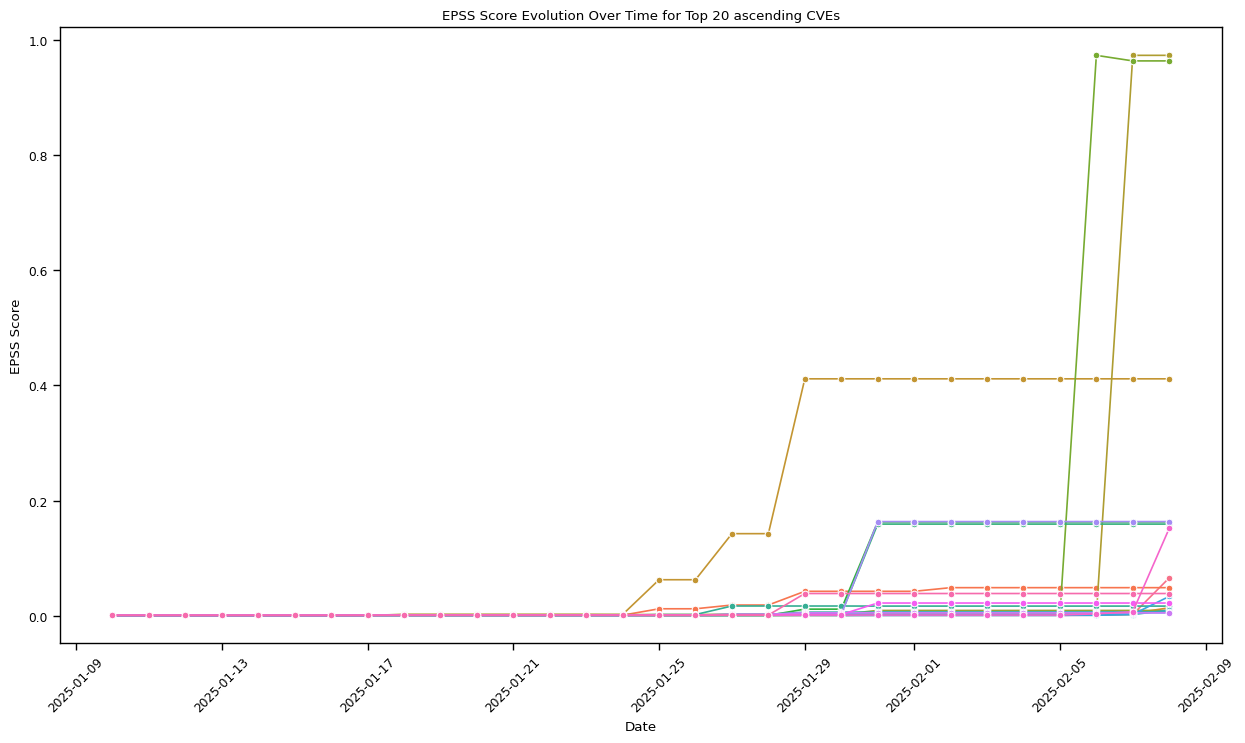

In [150]:
import seaborn as sns

# find all CVE with the highest ascending rate across the months starting from the oldest month to the latest month
epss_scores_sc["rate"] = epss_scores_sc.iloc[:, 1:].pct_change(axis=1).mean(axis=1)
epss_scores_sc = epss_scores_sc.sort_values(by="rate", ascending=True)
top_cves = epss_scores_sc.head(20)
top_cves = top_cves.drop(columns="rate")
top_cves = top_cves.set_index("cve").T

# Create a DataFrame with dates and scores, excluding non-date rows
date_rows = [idx for idx in top_cves.index if idx.startswith('scores_')]
top_cves_filtered = top_cves.loc[date_rows]
top_cves_filtered["date"] = [d.replace("scores_", "") for d in top_cves_filtered.index]

# Melt and process the data
melted_df = top_cves_filtered.melt(id_vars="date", var_name="cve", value_name="score")
melted_df["date"] = pd.to_datetime(melted_df["date"])
melted_df = melted_df.sort_values("date")

# Plot the results
plt.figure(figsize=(15, 8))
sns.set_context("paper", font_scale=1)
lines = sns.lineplot(data=melted_df, x="date", y="score", hue="cve", marker="o", legend=False)
plt.title("EPSS Score Evolution Over Time for Top 20 ascending CVEs")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("EPSS Score")
# Add CVE labels at the end points, slightly offset for better visibility
import plotly.express as px
import plotly.graph_objects as go

# Melt the data for plotly
melted_data = melted_df.copy()

# Create figure
fig = go.Figure()

# Add traces for each CVE
for cve in melted_data['cve'].unique():
    cve_data = melted_data[melted_data['cve'] == cve]
    fig.add_trace(go.Scatter(
        x=cve_data['date'],
        y=cve_data['score'],
        name=f"{cve} ({cve_data['score'].iloc[-1]:.5f})",
        mode='lines+markers'
    ))

# Update layout
fig.update_layout(
    title='EPSS Score Evolution Over Time for Top 20 ascending CVEs',
    xaxis_title='Date',
    yaxis_title='EPSS Score',
    hovermode='x unified',
    width=1200,
    height=800,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05
    )
)

fig.show()





In [138]:
# show what is the fraction of the top ascending scores CVES within the number of CVEs
top_cves_count = len(top_cves)
total_cves_count = len(epss_scores_sc)
top_cves_fraction = top_cves_count / total_cves_count
print(f"Top ascending scores CVEs: {top_cves_count}")
print(f"Total CVEs: {total_cves_count}")
print(f"Fraction of Top ascending scores CVEs: {top_cves_fraction:.2f}")


Top ascending scores CVEs: 30
Total CVEs: 129860
Fraction of Top ascending scores CVEs: 0.00
